In [2]:
import socket, warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex:
    raise Exception("No internet")

In [1]:
from duckduckgo_search import DDGS
from fastcore.all import *

def search_images(keywords, max_images=200):
    return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')

In [3]:
import time, json

In [4]:
urls = search_images('dog photos', max_images=1)
urls[0]

'https://images.pexels.com/photos/257540/pexels-photo-257540.jpeg?cs=srgb&dl=pexels-pixabay-257540.jpg&fm=jpg'

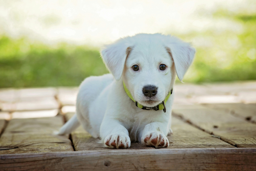

In [6]:
import os
from fastdownload import download_url
if not os.path.exists("images"):
    os.makedirs("images")
dest = 'images/dog.jpg'
download_url(urls[0], dest, show_progress=True)

from fastai.vision.all import *
image = Image.open(dest)
image.to_thumb(256, 256)

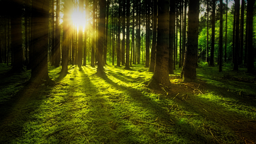

In [9]:
# download a random thing like forests to test against dog
download_url(search_images('forest photos', max_images=1)[0], 'images/forest.jpg')
Image.open('images/forest.jpg').to_thumb(256, 256)

In [11]:
searches = 'forest', 'dog'
path = Path('dog_or_not')

for i in searches:
    dest = (path/i)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{i} photo'))
    time.sleep(5)
    resize_images(path/i, max_size=400, dest=path/i)

/opt/miniconda3/envs/py310/lib/python3.10/site-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)
/opt/miniconda3/envs/py310/lib/python3.10/site-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)
/opt/miniconda3/envs/py310/lib/python3.10/site-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)
/opt/miniconda3/envs/py310/lib/python3.10/site-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)
/opt/miniconda3/envs/py310/lib/python3.10/site-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)
/opt/miniconda3/envs/py310/lib/python3.10/site-packages/PIL/Image.py:1043: UserWarnin

In [13]:
# remove the failed images
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

In [14]:
# double check
import glob
for f in glob.glob('dog_or_not/**/*jpg!d', recursive=True):
    os.remove(f)

In [15]:
# count number of files
from pathlib import Path

dog_files = list((Path('dog_or_not')/'dog').glob('*'))
forest_files = list((Path('dog_or_not')/'forest').glob('*'))

print(f"Dog images: {len(dog_files)}")
print(f"Forest images: {len(forest_files)}")

Dog images: 175
Forest images: 177


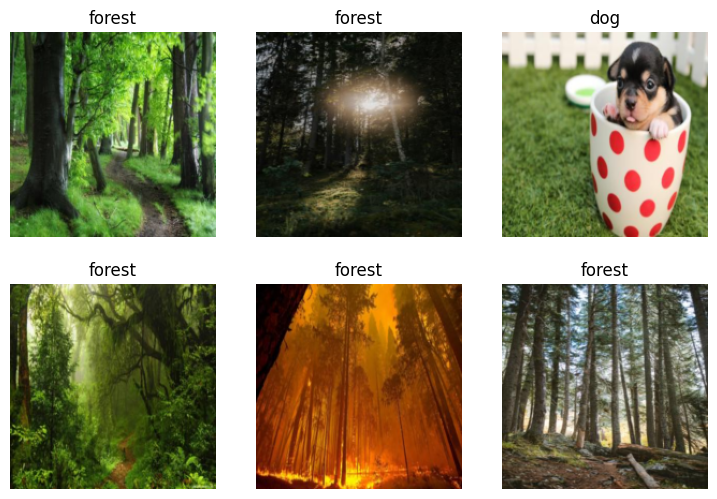

In [17]:
# create a datablock
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y = parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [18]:
# train the model
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/declanng/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 23.7MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.700226,0.126327,0.028571,00:06


epoch,train_loss,valid_loss,error_rate,time
0,0.025053,0.046104,0.014286,00:02
1,0.034527,0.023772,0.014286,00:01
2,0.021854,0.007563,0.000000,00:01


In [ ]:
# try the model on our first image
is_bird, _, probs = learn.predict(PILImage.create('images/dog.jpg'))
print(f"This is a {is_bird}")
print(f"Probability it's a dog {probs[0]:.4f}")

This is a forest
Probability it's a dog 0.0001
